In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy.fft as fft
from scipy import signal as scisig
from viterbi_utils import *
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

In [2]:
df_train = pd.read_pickle('../features/train_clean.pkl')
df_test = pd.read_pickle('../features/test_clean.pkl')
TARGET = "open_channels"
df_test[TARGET] = 0

df_train["group"] = df_train["batch"].astype("str") + "_" + df_train["mini_batch"].astype("str")
df_test["group"] = df_test["batch"].astype("str") + "_" + df_test["mini_batch"].astype("str")

df_train["signal_original"] = df_train["signal"].copy()
df_test["signal_original"] = df_test["signal"].copy()

print(f"train size:{df_train.shape}, test size:{df_test.shape}")
df_train.head()

train size:(4500000, 8), test size:(2000000, 9)


,time,signal,open_channels,local_time,batch,mini_batch,group,signal_original
0,0.0001,-2.7600,0,0.0001,1,1,1_1,-2.7600
1,0.0002,-2.8557,0,0.0002,1,1,1_1,-2.8557
2,0.0003,-2.4074,0,0.0003,1,1,1_1,-2.4074
3,0.0004,-3.1404,0,0.0004,1,1,1_1,-3.1404
4,0.0005,-3.1525,0,0.0005,1,1,1_1,-3.1525


In [3]:
df_train.loc[df_train[TARGET] == 0, TARGET] = 1
df_train[TARGET] = df_train[TARGET] - 1

In [4]:
# mini model
BATCH_GROUP = [5]
df_train = df_train[df_train.batch.isin(BATCH_GROUP)].reset_index(drop=True)
TEST_GROUP = ["1_3", "2_2"]
df_test = df_test[df_test.group.isin(TEST_GROUP)].reset_index(drop=True)

print(f"train size:{df_train.shape}, test size:{df_test.shape}")

train size:(500000, 8), test size:(200000, 9)


In [5]:
def get_noise(batch, col=TARGET, Q=30):
    """
    input: batch df
    output: recovered signal
    """
    signal = batch.signal_original.values
    channels = batch[col].values
    sig_mean = get_mean(batch)
    sig_noise = Arrange_mean(signal, channels, sig_mean, len(sig_mean))
    
    return sig_noise

In [6]:
def get_noise_after_notch(batch, col=TARGET, Q=30):
    """
    input: batch df
    output: recovered signal
    """
    signal = batch.signal_original.values
    channels = batch[col].values
    sig_mean = get_mean(batch)
    sig_noise = Arrange_mean(signal, channels, sig_mean, len(sig_mean))
    sig_noise_notch_recovered = bandstop(sig_noise)
#     sig_noise_notch_recovered = bandstop(sig_noise)

    return sig_noise_notch_recovered

In [7]:
df_train["noise"] = 0
df_train["noise_notch"] = 0
df_train["minus"] = 0
Q_val = 90
# remove the 50 hz noise using notch filter
for group_i in df_train.group.unique():
    
    batch_i = df_train[df_train.group.isin([group_i])]
    signal_recovered = get_noise(batch_i, Q=Q_val)
    signal_recovered_notch = get_noise_after_notch(batch_i, Q=Q_val)
    df_train.loc[df_train.group.isin([group_i]), "noise"] = signal_recovered
    df_train.loc[df_train.group.isin([group_i]), "noise_notch"] = signal_recovered_notch
    df_train.loc[df_train.group.isin([group_i]), "minus"] = signal_recovered - signal_recovered_notch

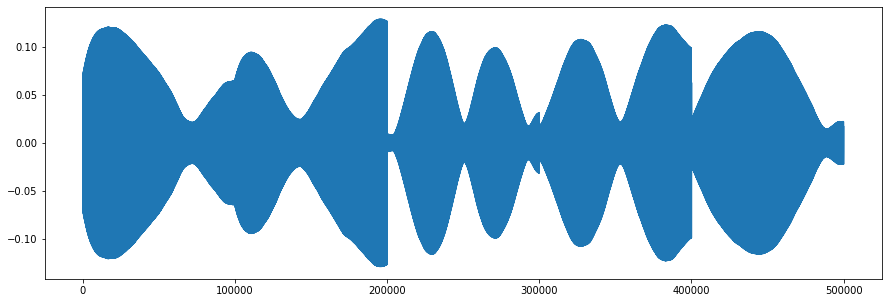

In [8]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_train.minus)
# plt.ylim([-0.3, 0.3])

In [1]:
fig = plt.figure(figsize=(15,5))

fs=10000
fft = np.fft.fft(df_train[df_train.group=='5_3'].noise_notch)
psd = np.abs(fft) ** 2
fftfreq = np.fft.fftfreq(len(psd),1/fs)

i = abs(fftfreq) < 200
plt.grid()
plt.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)

plt.show()


NameError: name 'plt' is not defined

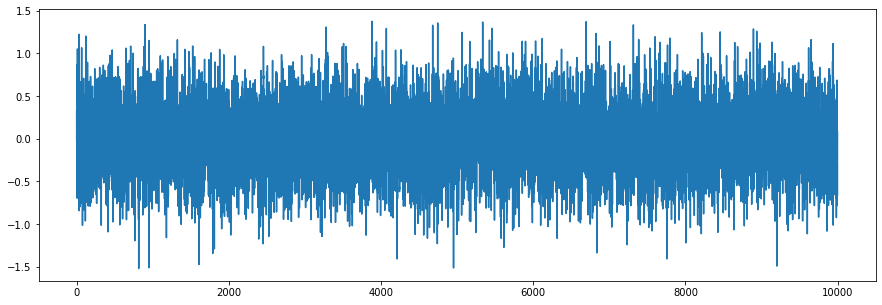

In [10]:
fig = plt.figure(figsize=(15,5))
plt.plot(df_train.noise_notch[:10000])

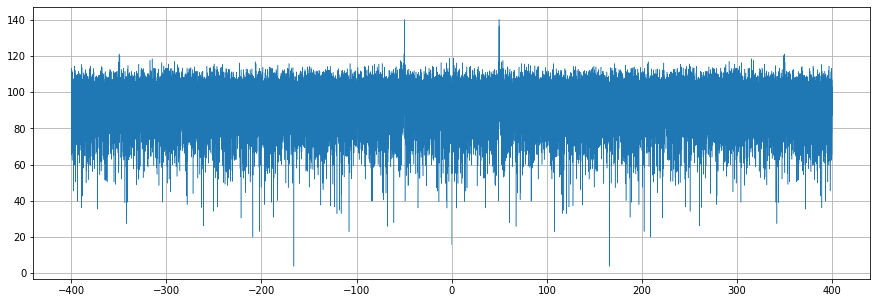

In [11]:
fig = plt.figure(figsize=(15,5))

fs=10000
fft = np.fft.fft(df_train.noise_notch)
psd = np.abs(fft) ** 2
fftfreq = np.fft.fftfreq(len(psd),1/fs)

i = abs(fftfreq) < 400
plt.grid()
plt.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)

plt.show()


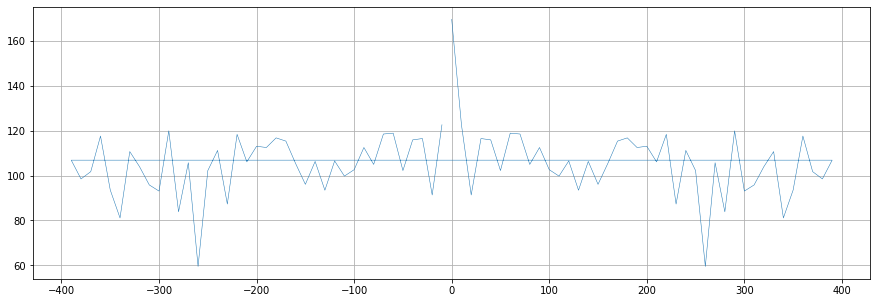

In [12]:
x = 10000
tmp = df_train[x:x+5000].signal.values
fig = plt.figure(figsize=(15,5))

fs=50000
fft = np.fft.fft(tmp)
psd = np.abs(fft) ** 2
fftfreq = np.fft.fftfreq(len(psd),1/fs)

i = abs(fftfreq) < 400
plt.grid()
plt.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)

plt.show()


In [13]:
stop

NameError: name 'stop' is not defined

In [ ]:
# remove the 50 hz noise using notch filter
for group_i in df_train.group.unique():

    batch_i = df_train[df_train.group.isin([group_i])]
    signal_recovered = rm_noise(batch_i, Q=70)
    df_train.loc[df_train.group.isin([group_i]), "signal"] = signal_recovered

In [ ]:
viterbi_cols = ["viterbi_" + str(i) for i in range(df_train[TARGET].nunique())]
for col in viterbi_cols:
    df_train[col] = 0
    df_test[col] = 0

In [ ]:
# see performance in each group
signal = df_train.loc[df_train.batch.isin(BATCH_GROUP), "signal"]
state = df_train.loc[df_train.batch.isin(BATCH_GROUP), TARGET]
viterbi = PosteriorDecoder().fit(signal, state)
for group_i in df_train.group.unique():
    batch_i = df_train[df_train.group.isin([group_i])]
    signal_i = df_train.loc[df_train.group.isin([group_i]), "signal"]
    state_i = df_train.loc[df_train.group.isin([group_i]), TARGET]
    df_train.loc[df_train.group.isin([group_i]), viterbi_cols], df_train.loc[df_train.group.isin([group_i]), "oof"] = viterbi.predict(signal_i)
    print(group_i, "F1 macro =", f1_score(y_pred=df_train.loc[df_train.group.isin([group_i]), "oof"], y_true=state_i, average='macro').round(6))

print("==> OOF F1 macro =", f1_score(y_pred=df_train["oof"].values, y_true=df_train[TARGET].values, average='macro').round(4))

In [ ]:
# predict the test
for col in TEST_GROUP:
    df_test.loc[df_test.group == col, viterbi_cols], df_test.loc[df_test.group == col, "oof"] = viterbi.predict(df_test.loc[df_test.group == col, "signal"].values)

# remove test signal noise here using oof
df_test["noise"] = 0
df_test["noise_notch"] = 0
Q_val = 70
# remove the 50 hz noise using notch filter
for group_i in TEST_GROUP:
    batch_test_i = df_test[df_test.group.isin([group_i])].copy()
    signal_test_recovered = rm_noise(batch_test_i, col="oof", Q=60)
    df_test.loc[df_test.group.isin([group_i]), "signal"] = signal_test_recovered

    signal_recovered = get_noise(batch_test_i, col="oof", Q=Q_val)
    signal_recovered_notch = get_noise_after_notch(batch_test_i, col="oof", Q=Q_val)
    df_test.loc[df_test.group.isin([group_i]), "noise"] = signal_recovered
    df_test.loc[df_test.group.isin([group_i]), "noise_notch"] = signal_recovered_notch

# re-predict test 
for group_i in TEST_GROUP:
    df_test.loc[df_test.group == group_i, viterbi_cols], df_test.loc[df_test.group == group_i, TARGET] = viterbi.predict(df_test.loc[df_test.group == group_i, "signal"].values)

In [ ]:
fig = plt.figure(figsize=(15,5))

fs=10000
fft = np.fft.fft(df_test.noise)
psd = np.abs(fft) ** 2
fftfreq = np.fft.fftfreq(len(psd),1/fs)

i = abs(fftfreq) < 200
plt.grid()
plt.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)

plt.show()


In [14]:
df_train.head()

,time,signal,open_channels,local_time,batch,mini_batch,group,signal_original,noise,noise_notch,minus
0,200.000107,7.1191,9,0.000107,5,1,5_1,7.1191,0.252583,0.321165,-0.068582
1,200.000198,6.7712,9,0.000198,5,1,5_1,6.7712,-0.095317,-0.026261,-0.069056
2,200.000305,6.9278,9,0.000305,5,1,5_1,6.9278,0.061283,0.130746,-0.069463
3,200.000397,7.3541,9,0.000397,5,1,5_1,7.3541,0.487583,0.557384,-0.069800
4,200.000504,7.4194,9,0.000504,5,1,5_1,7.4194,0.552883,0.622953,-0.070069


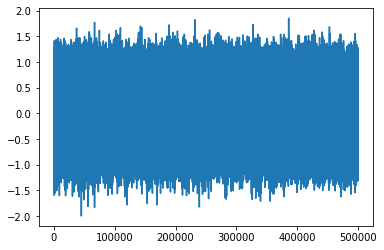

In [16]:
plt.plot(df_train.noise)

In [26]:
import math
def parabolic_drift_fit(data):
    x = data['local_time']
    y = data['minus']

    frequency = 50
    omega = 2 * np.pi * frequency
    M = np.array([[np.sin(omega * t), np.cos(omega * t), 1] for t in x])
    y = np.array(y).reshape(len(y), 1)

    (theta, _, _, _) = np.linalg.lstsq(M, y)
    
    A = np.sqrt(theta[0,0]**2 + theta[1,0]**2)
    ph = math.atan2(theta[1,0], theta[0,0])
    d = theta[2,0]

    popt = [A, ph, d]
    print(np.array(popt).round(5))
    return popt
sin_w = parabolic_drift_fit(df_train)

[ 0.0107 -2.9732  0.    ]


In [27]:
for group_i in df_train.group.unique():
    parabolic_drift_fit(df_train[df_train.group == group_i])

[ 6.20100e-02 -2.78526e+00  1.00000e-05]
[ 4.95100e-02 -2.31334e+00  5.00000e-05]
[ 2.95000e-02  3.10819e+00 -1.00000e-05]
[ 5.6540e-02  1.9065e-01 -2.0000e-05]
[ 3.95900e-02  1.24039e+00 -1.00000e-05]
